# Cross-Validation



In [ ]:
#Run once per session
!pip install fastai -q --upgrade

## What is K-Fold Cross Validation?

* A way to get the most out of your data
* More models
* Ensembling
* Requires more training 

## What is needed?

* Training set
* Test set

* Why no validation?

## ImageWoof

In [ ]:
from fastai.vision.all import *

In [ ]:
path = untar_data(URLs.IMAGEWOOF)

In [ ]:
path.ls()

(#2) [Path('/root/.fastai/data/imagewoof2/val'),Path('/root/.fastai/data/imagewoof2/train')]

Scenario:

* We have a training set
* We have a test set

In [ ]:
batch_tfms = [IntToFloatTensor(), *aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]
item_tfms = [ToTensor(), RandomResizedCrop(460, min_scale=0.75, ratio=(1.,1.))]
bs=64

IndexSplitter

In [ ]:
IndexSplitter??

In [ ]:
train_imgs = get_image_files(path/'train')
tst_imgs = get_image_files(path/'val')

We'll shuffle up our training set so the chance of including all classes is almost guarenteed

In [ ]:
random.shuffle(train_imgs)

In [ ]:
len(train_imgs)

9025

And then we will do an 80/20 split

In [ ]:
train_imgs

(#9025) [Path('/root/.fastai/data/imagewoof2/train/n02087394/n02087394_24815.JPEG'),Path('/root/.fastai/data/imagewoof2/train/n02088364/n02088364_203.JPEG'),Path('/root/.fastai/data/imagewoof2/train/n02111889/n02111889_6387.JPEG'),Path('/root/.fastai/data/imagewoof2/train/n02093754/n02093754_4705.JPEG'),Path('/root/.fastai/data/imagewoof2/train/n02099601/n02099601_1687.JPEG'),Path('/root/.fastai/data/imagewoof2/train/n02087394/n02087394_29644.JPEG'),Path('/root/.fastai/data/imagewoof2/train/n02111889/n02111889_3326.JPEG'),Path('/root/.fastai/data/imagewoof2/train/n02111889/n02111889_338.JPEG'),Path('/root/.fastai/data/imagewoof2/train/n02086240/n02086240_7215.JPEG'),Path('/root/.fastai/data/imagewoof2/train/n02086240/n02086240_3937.JPEG')...]

In [ ]:
start_val = len(train_imgs) - int(len(train_imgs)*.2)

In [ ]:
idxs = list(range(start_val, len(train_imgs)))

In [ ]:
splits = IndexSplitter(idxs)

In [ ]:
split = splits(train_imgs)

In [ ]:
len(train_imgs)

9025

In [ ]:
split_list = [split[0], split[1]]

In [ ]:
split_list.append(L(range(len(train_imgs), len(train_imgs)+len(tst_imgs))))

In [ ]:
split_list

[(#7220) [0,1,2,3,4,5,6,7,8,9...],
 (#1805) [7220,7221,7222,7223,7224,7225,7226,7227,7228,7229...],
 (#3929) [9025,9026,9027,9028,9029,9030,9031,9032,9033,9034...]]

Let's check

In [ ]:
dsrc = Datasets(train_imgs+tst_imgs, tfms=[[PILImage.create], [parent_label, Categorize]],
                splits = split_list)

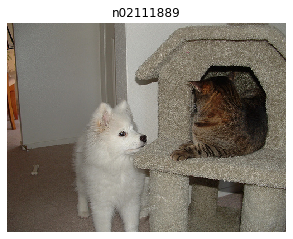

In [ ]:
show_at(dsrc.train, 3)

In [ ]:
dsrc.n_subsets

3

In [ ]:
dls = dsrc.dataloaders(bs=bs, after_item=item_tfms, after_batch=batch_tfms)

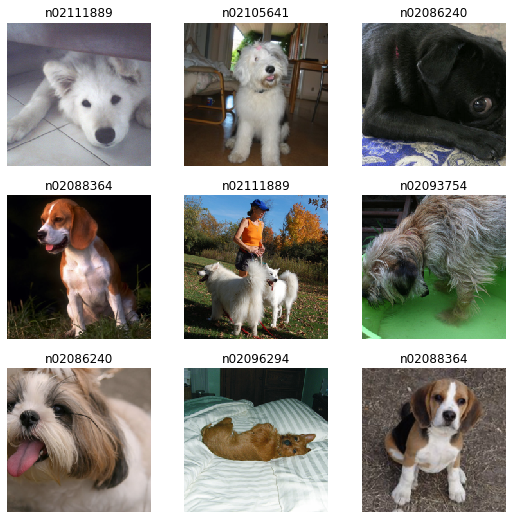

In [ ]:
dls.show_batch()

In [ ]:
dls.n_subsets

3

Let's do a quick baseline

In [ ]:
learn = cnn_learner(dls, resnet34, pretrained=False, metrics=accuracy).to_fp16()

In [ ]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,3.695789,2.553430,0.080000,00:10


Now how do we check it?

We can run `learn.validate` on our subset

In [ ]:
learn.validate(ds_idx=2)

(#2) [2.9579572677612305,0.009999999776482582]

# Now **how** do I do Cross-Validation?

In [ ]:
from sklearn.model_selection import StratifiedKFold

First let's grab all the labels from our dataset

In [ ]:
train_labels = L()
for i in range(len(dsrc.train)):
  train_labels.append(dsrc.train[i][1])
for i in range(len(dsrc.valid)):
  train_labels.append(dsrc.valid[i][1])
train_labels

Now let's make our K-Fold

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=True)

Finally we need to define a training loop to go over all our folds and gather our validation and test accuracy

In [ ]:
n_splits = 10

In [ ]:
import random
random.shuffle(train_imgs)

What's our loop going to look like?

In [ ]:
val_pct = []
tst_preds = []
skf = StratifiedKFold(n_splits=10, shuffle=True)
for _, val_idx in kf.split(np.array(train_imgs), train_labels):
  splits = IndexSplitter(val_idx)
  split = splits(train_imgs)
  split_list = [split[0], split[1]]
  split_list.append(L(range(len(train_imgs), len(train_imgs)+len(tst_imgs))))
  dsrc = Datasets(train_imgs+tst_imgs, tfms=[[PILImage.create], [parent_label, Categorize]],
                  splits=split_list)
  dls = dsrc.dataloaders(bs=bs, after_item=item_tfms, after_batch=batch_tfms)
  learn = cnn_learner(dls, resnet34, pretrained=False, metrics=accuracy)
  learn.fit_one_cycle(1)
  val_pct.append(learn.validate()[1])
  a,b = learn.get_preds(ds_idx=2)
  tst_preds.append(a)

epoch,train_loss,valid_loss,accuracy,time
0,2.719507,2.042494,0.238095,01:31


epoch,train_loss,valid_loss,accuracy,time
0,2.751266,2.086211,0.227021,01:34


epoch,train_loss,valid_loss,accuracy,time
0,2.707963,2.138007,0.234773,01:37


epoch,train_loss,valid_loss,accuracy,time
0,2.796831,2.056918,0.256921,01:33


epoch,train_loss,valid_loss,accuracy,time
0,2.770414,2.128132,0.211517,01:35


epoch,train_loss,valid_loss,accuracy,time
0,2.797058,2.139611,0.211752,01:30


epoch,train_loss,valid_loss,accuracy,time
0,2.778126,2.101697,0.252772,01:29


epoch,train_loss,valid_loss,accuracy,time
0,2.709981,2.061131,0.258315,01:27


epoch,train_loss,valid_loss,accuracy,time
0,2.767529,2.067217,0.252772,01:26


epoch,train_loss,valid_loss,accuracy,time
0,2.787489,2.056555,0.252772,01:26


Now how do we combine all our predictions? We sum them all together then divide by our total

In [ ]:
tst_preds_copy = tst_preds.copy()

In [ ]:
accuracy(tst_preds_copy[0], b)

TensorCategory(0.2627)

In [ ]:
for i in tst_preds_copy:
  print(accuracy(i, b))

TensorCategory(0.2627)
TensorCategory(0.2451)
TensorCategory(0.2349)
TensorCategory(0.2527)
TensorCategory(0.2349)
TensorCategory(0.2306)
TensorCategory(0.2403)
TensorCategory(0.2568)
TensorCategory(0.2451)
TensorCategory(0.2420)


Now let's add them all together and get an average prediction

In [ ]:
hat = tst_preds[0]
for pred in tst_preds[1:]:
  hat += pred

In [ ]:
hat

tensor([[0.3902, 1.5066, 0.9855,  ..., 0.2361, 0.2046, 2.4240],
        [0.4634, 1.7225, 0.9483,  ..., 0.2826, 0.1854, 1.1360],
        [0.2495, 2.1242, 0.4055,  ..., 0.0850, 0.1285, 1.2317],
        ...,
        [0.2474, 2.0897, 0.2683,  ..., 0.1040, 0.1051, 2.4141],
        [0.6661, 1.5541, 0.5160,  ..., 0.4528, 0.5402, 2.0298],
        [0.3856, 1.6319, 0.5222,  ..., 0.1828, 0.1399, 2.2385]])

In [ ]:
hat /= len(tst_preds)

In [ ]:
accuracy(hat, b)

TensorCategory(0.2899)

That's an improvement of at most 6%!